# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np

# Database creations using pytorch Dataset 

In [ ]:
class ImageAuthenticityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels


# Definitions of the models

In [ ]:
class AuthenticityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Predict authenticity
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = 'Dataset/AIGCIQA2023/real_images_annotations.csv'

# Create the dataset
dataset = ImageAuthenticityDataset(csv_file=annotations_file, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 1 # Set to 1 for handling individual images

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# create a susset of the test dataset for testing
test_subset_size = 10
test_subset_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)
test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)
test_subset = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create a dictionary containing the data loaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

model = AuthenticityPredictor()
criterion = nn.MSELoss()  # Mean Squared Error Loss (regression)
optimizer = optim.Adam(model.regression_head.parameters(), lr=0.001)



## Compute for each image the importace scores of lastConv layer's channels

In [ ]:
def compute_obj_x_obj_feature_map_importance(model, dataloader, device, layer_name):
    """Computes the importance of each feature map in a convolution layer by measuring the change in 
    predictions when the feature map is zeroed out, calculated per object.
    
    Args:
        model (nn.Module): The trained model
        dataloader (DataLoader): Dataloader containing the images (with batch_size=1)
        device (str): Device to run computation on ('cuda' or 'cpu')
        layer_name (str): Name of the layer to analyze
        
    Returns:
        numpy.ndarray: An array where each element is a numpy array of channel importance scores
                      for the corresponding image. Shape: [num_images]
    """
    # Check if importance scores are already computed
    if os.path.exists('Ranking_arrays/Dual_scores_obj_x_obj_authenticity_importance_scores.npy'):
        print("Per-object importance scores already computed, loading from file")
        return np.load('Ranking_arrays/Dual_scores_obj_x_obj_authenticity_importance_scores.npy', allow_pickle=True)
    
    model.eval()
    model.to(device)
    named_modules = list(model.named_modules())
    layer = None
    
    for name, module in named_modules:
        if name == layer_name:
            layer = module
            break
    
    if layer is None:
        raise ValueError(f"Layer {layer_name} not found in model")
    
    num_channels = layer.out_channels
    
    # Make sure batch_size=1 in the dataloader
    if dataloader.batch_size != 1:
        print("Warning: Dataloader batch size should be 1 for per-object importance computation")
    
    # Create a directory for saving results if it doesn't exist
    os.makedirs('Ranking_arrays', exist_ok=True)
    
    # Initialize array to store importance scores arrays for each image
    num_images = len(dataloader)
    importance_array = np.empty(num_images, dtype=float)
    
    # Process each image individually
    for img_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Processing image {img_idx}/{num_images}")
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get baseline prediction
        with torch.no_grad():
            baseline_outputs, _ = model(inputs)
            y_true = labels
            y_pred = baseline_outputs.item()
            residual_error = torch.abs(y_pred - y_true).item()
        print(f"Baseline True Value: {labels}, Baseline prediction: {y_pred}, Residual error: {residual_error}")
        # Initialize array for this image's channel importance scores
        channel_residual_scores = np.zeros(num_channels)
        pred_residual_scores = np.zeros(num_channels)

        
        # Compute importance for each feature map for this image
        for channel_idx in range(num_channels):
            # Create a backup of the weights and bias
            backup_weights = layer.weight[channel_idx, ...].clone()
            backup_bias = layer.bias[channel_idx].clone() if layer.bias is not None else None
            
            # Zero out the channel_idx-th output channel
            with torch.no_grad():
                layer.weight[channel_idx, ...] = 0
                if layer.bias is not None:
                    layer.bias[channel_idx] = 0
                
            # Get prediction with the pruned feature map
            with torch.no_grad():
                pruned_outputs, _ = model(inputs)
                y_pred_pruned = pruned_outputs.item()
                residual_error_pruned = torch.abs(y_pred_pruned - y_true).item()
            
            print(f"Channel {channel_idx}: True Value: {labels}, Prediction with channel pruned: {y_pred_pruned}, Residual error: {residual_error_pruned}")
            
            # Compute scores
            delta_residual = residual_error_pruned - residual_error # how prediction error changes when we remove a feature map
            delta_prediction = y_pred_pruned - y_pred # how the predicted realism score changes when we remove the feature map
            
            channel_residual_scores[channel_idx] = delta_residual
            pred_residual_scores[channel_idx] = delta_prediction
            
            # Restore weights and bias
            with torch.no_grad():
                layer.weight[channel_idx, ...] = backup_weights
                if layer.bias is not None:
                    layer.bias[channel_idx] = backup_bias
        
        # Store the channel scores array for this image
        importance_array[img_idx] = np.array([channel_residual_scores, pred_residual_scores])
    
    # Save results as a numpy array
    np.save('Ranking_arrays/Dual_scores_obj_x_obj_authenticity_importance_scores.npy', importance_array)
    
    # Return the array of arrays
    return importance_array

In [ ]:

# LAYER to prune 
LAYER = 'features.28'  # Last convolutional layer (assuming it has 512 channels)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure batch size is 1
BATCH_SIZE = 1


# Load the model
model = AuthenticityPredictor()
model.load_state_dict(torch.load('Models/VGG-16_real_authenticity_finetuned.pth'))
model.eval()
model.to(DEVICE)

# Compute per-object feature importance
obj_x_obj_importance = compute_obj_x_obj_feature_map_importance(model, dataloaders['test'], DEVICE, LAYER)





In [ ]:


#calculate the meanorrelation between the two scores
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the first image's scores
p_correlation_scores = []
rho_correlation_scores = []
for i in range(len(obj_x_obj_importance)):
    channel_residual_scores = obj_x_obj_importance[i][0]
    pred_residual_scores = obj_x_obj_importance[i][1]

    # Calculate the correlation
    corr, _ = stats.pearsonr(channel_residual_scores, pred_residual_scores)
    print(f"Correlation: {corr}")
    rho, _ = stats.spearmanr(channel_residual_scores, pred_residual_scores)
    print(f"Spearman Correlation: {rho}")

    p_correlation_scores.append(corr)
    rho_correlation_scores.append(rho)

plt.figure(figsize=(10, 6))

# Option 1: Use the stat parameter in histplot to show density, then multiply by 100
sns.histplot(p_correlation_scores, bins=20, kde=True, color='blue', stat='density')
plt.title('Distribution of Pearson Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Percentage (%)')
# Since density integrates to 1, we need to multiply by bin width and 100 to get percentage
bin_width = (max(p_correlation_scores) - min(p_correlation_scores)) / 20
y_ticks = plt.yticks()[0]
plt.yticks(y_ticks, [f'{y * bin_width * 100:.1f}%' for y in y_ticks])
plt.grid()

# Option 2: Alternative approach using hist with weights parameter
# plt.hist(p_correlation_scores, bins=20, weights=np.ones(len(p_correlation_scores))/len(p_correlation_scores)*100,
#          alpha=0.7, color='blue', edgecolor='black')
# sns.kdeplot(p_correlation_scores, color='darkblue')
# plt.ylabel('Percentage (%)')

plt.show()



/tmp/ipykernel_2147598/3817911275.py:161: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=[


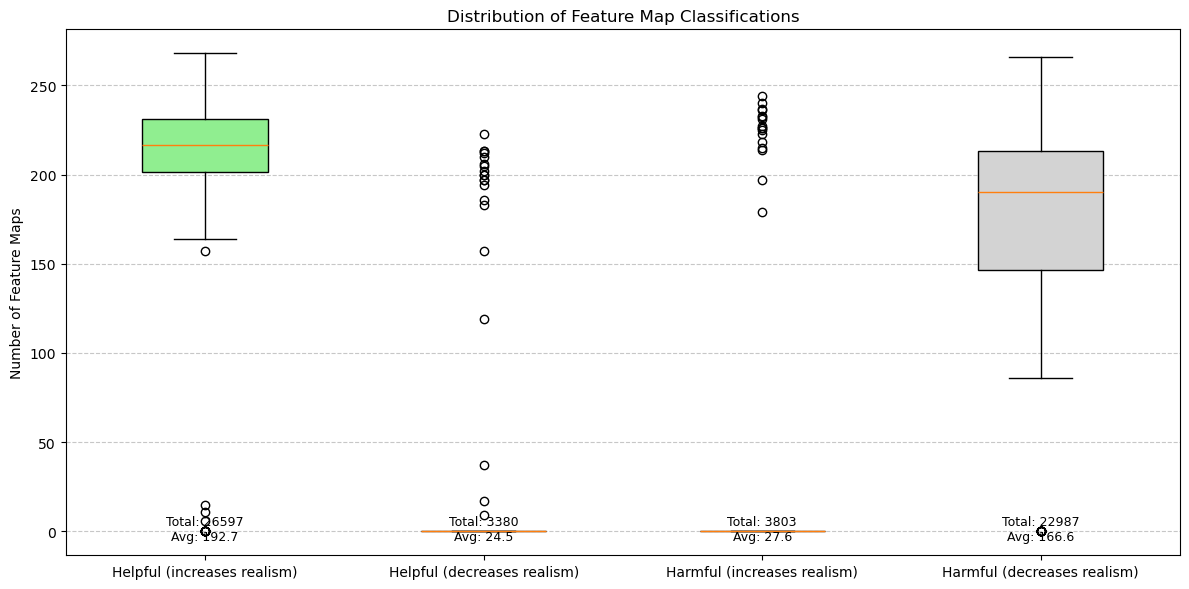

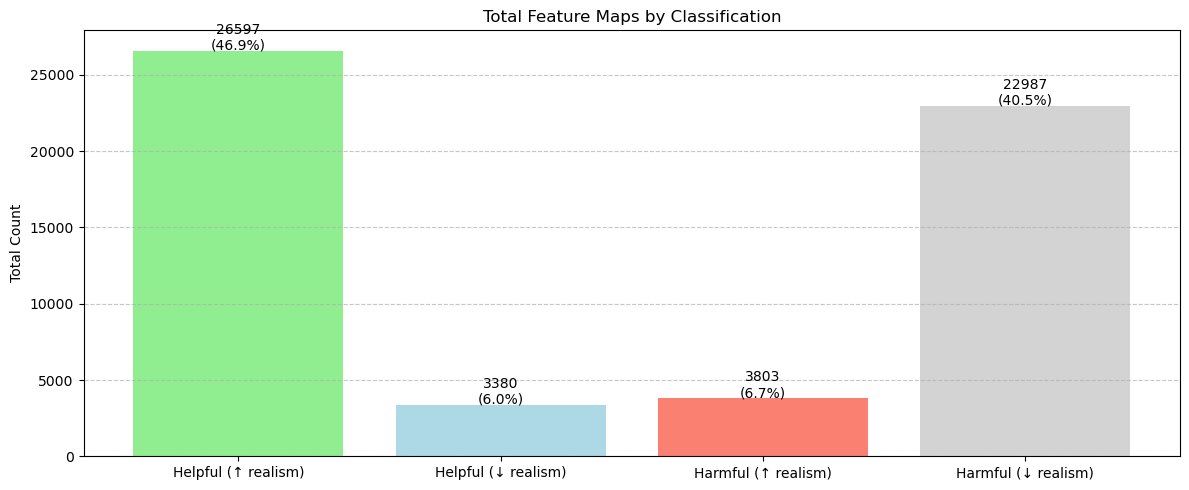

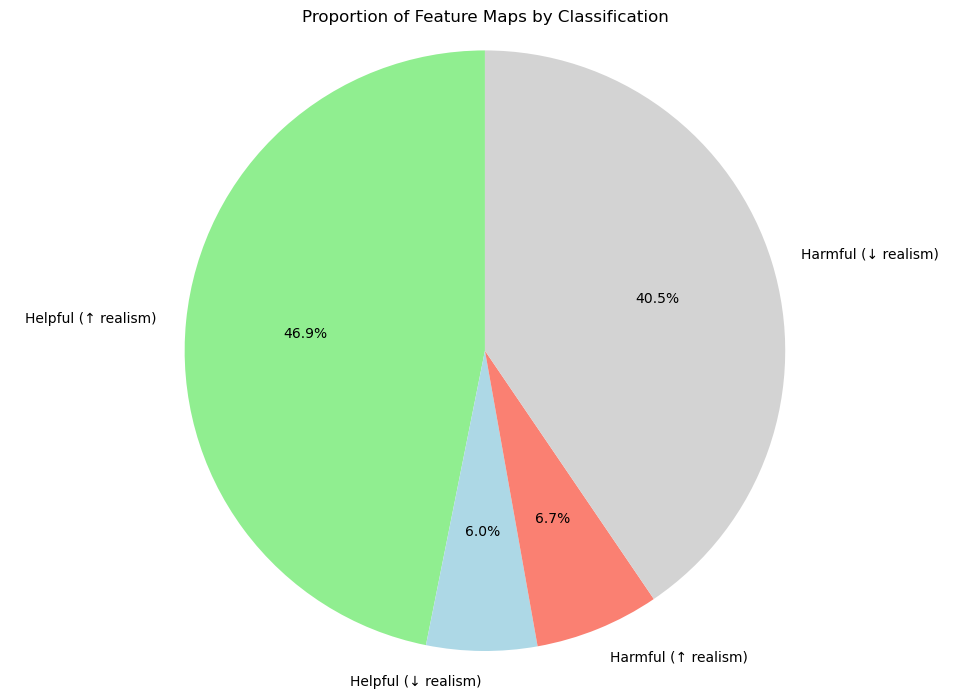

Average features per image in each category:
Helpful (↑ realism): 192.73
Helpful (↓ realism): 24.49
Harmful (↑ realism): 27.56
Harmful (↓ realism): 166.57


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def classify_feature_maps(obj_x_obj_importance):
    """
    Classifies feature maps based on their effect on prediction error and realism score
    when they are pruned from the network.
    
    Args:
        obj_x_obj_importance: NumPy array containing importance scores for each image
            Each element has two arrays: channel_residual_scores and pred_residual_scores
    
    Returns:
        Dictionary containing classification counts and detailed information
    """
    # Dictionary to store classification information
    classification_dict = {
        'helpful_increase_realism': {
            'description': 'Feature maps that increase realism (helpful)',
            'criteria': 'Δerror > 0 (error ↑) and Δy < 0 (realism ↓)',
            'counts_per_image': [],
            'channel_indices_per_image': [],
            'total_count': 0
        },
        'helpful_decrease_realism': {
            'description': 'Feature maps that decrease realism (helpful)',
            'criteria': 'Δerror > 0 (error ↑) and Δy > 0 (realism ↑)',
            'counts_per_image': [],
            'channel_indices_per_image': [],
            'total_count': 0
        },
        'harmful_increase_realism': {
            'description': 'Feature maps that increase realism (harmful)',
            'criteria': 'Δerror < 0 (error ↓) and Δy < 0 (realism ↓)',
            'counts_per_image': [],
            'channel_indices_per_image': [],
            'total_count': 0
        },
        'harmful_decrease_realism': {
            'description': 'Feature maps that decrease realism (harmful)',
            'criteria': 'Δerror < 0 (error ↓) and Δy > 0 (realism ↑)',
            'counts_per_image': [],
            'channel_indices_per_image': [],
            'total_count': 0
        }
    }
    
    # Dictionary to track counts per channel across all images
    channel_classifications = defaultdict(lambda: defaultdict(int))
    
    # Process each image
    for img_idx, scores in enumerate(obj_x_obj_importance):
        channel_residual_scores = scores[0]  # Δerror
        pred_residual_scores = scores[1]     # Δy
        
        # Initialize channel indices for each category for this image
        helpful_increase_realism_indices = []
        helpful_decrease_realism_indices = []
        harmful_increase_realism_indices = []
        harmful_decrease_realism_indices = []
        
        # Classify each feature map
        for channel_idx in range(len(channel_residual_scores)):
            delta_error = channel_residual_scores[channel_idx]
            delta_y = pred_residual_scores[channel_idx]
            
            # Helpful, increases realism: error↑, realism↓
            if delta_error > 0 and delta_y < 0:
                helpful_increase_realism_indices.append(channel_idx)
                channel_classifications[channel_idx]['helpful_increase_realism'] += 1
            
            # Helpful, decreases realism: error↑, realism↑
            elif delta_error > 0 and delta_y > 0:
                helpful_decrease_realism_indices.append(channel_idx)
                channel_classifications[channel_idx]['helpful_decrease_realism'] += 1
            
            # Harmful, increases realism: error↓, realism↓
            elif delta_error < 0 and delta_y < 0:
                harmful_increase_realism_indices.append(channel_idx)
                channel_classifications[channel_idx]['harmful_increase_realism'] += 1
            
            # Harmful, decreases realism: error↓, realism↑
            elif delta_error < 0 and delta_y > 0:
                harmful_decrease_realism_indices.append(channel_idx)
                channel_classifications[channel_idx]['harmful_decrease_realism'] += 1
        
        # Store counts and indices for this image
        classification_dict['helpful_increase_realism']['counts_per_image'].append(len(helpful_increase_realism_indices))
        classification_dict['helpful_increase_realism']['channel_indices_per_image'].append(helpful_increase_realism_indices)
        
        classification_dict['helpful_decrease_realism']['counts_per_image'].append(len(helpful_decrease_realism_indices))
        classification_dict['helpful_decrease_realism']['channel_indices_per_image'].append(helpful_decrease_realism_indices)
        
        classification_dict['harmful_increase_realism']['counts_per_image'].append(len(harmful_increase_realism_indices))
        classification_dict['harmful_increase_realism']['channel_indices_per_image'].append(harmful_increase_realism_indices)
        
        classification_dict['harmful_decrease_realism']['counts_per_image'].append(len(harmful_decrease_realism_indices))
        classification_dict['harmful_decrease_realism']['channel_indices_per_image'].append(harmful_decrease_realism_indices)
    
    # Calculate total counts for each category
    classification_dict['helpful_increase_realism']['total_count'] = sum(classification_dict['helpful_increase_realism']['counts_per_image'])
    classification_dict['helpful_decrease_realism']['total_count'] = sum(classification_dict['helpful_decrease_realism']['counts_per_image'])
    classification_dict['harmful_increase_realism']['total_count'] = sum(classification_dict['harmful_increase_realism']['counts_per_image'])
    classification_dict['harmful_decrease_realism']['total_count'] = sum(classification_dict['harmful_decrease_realism']['counts_per_image'])
    
    # Add channel consistency analysis (how consistently a channel falls into a specific category)
    classification_dict['channel_consistency'] = {}
    for channel_idx in range(len(obj_x_obj_importance[0][0])):  # Assuming all images have same number of channels
        classification_dict['channel_consistency'][channel_idx] = {}
        for category in ['helpful_increase_realism', 'helpful_decrease_realism', 
                         'harmful_increase_realism', 'harmful_decrease_realism']:
            count = channel_classifications[channel_idx][category]
            percentage = (count / len(obj_x_obj_importance)) * 100
            classification_dict['channel_consistency'][channel_idx][category] = {
                'count': count,
                'percentage': percentage
            }
    
    # Add most consistent channels per category
    classification_dict['most_consistent_channels'] = {}
    for category in ['helpful_increase_realism', 'helpful_decrease_realism', 
                     'harmful_increase_realism', 'harmful_decrease_realism']:
        # Sort channels by consistency percentage in this category
        sorted_channels = sorted(
            [(channel_idx, info[category]['percentage']) 
             for channel_idx, info in classification_dict['channel_consistency'].items()],
            key=lambda x: x[1],
            reverse=True
        )
        classification_dict['most_consistent_channels'][category] = sorted_channels[:10]  # Top 10 channels
    
    return classification_dict

# Example usage (assuming obj_x_obj_importance is loaded):
obj_x_obj_importance = np.load('Ranking_arrays/Dual_scores_obj_x_obj_authenticity_importance_scores.npy', allow_pickle=True)
classification_dict = classify_feature_maps(obj_x_obj_importance)

def visualize_classification_distribution(classification_dict):
    """
    Visualizes the distribution of feature map classifications across images.
    
    Args:
        classification_dict: Dictionary containing classification information
    """
    categories = [
        'helpful_increase_realism',
        'helpful_decrease_realism', 
        'harmful_increase_realism',
        'harmful_decrease_realism'
    ]
    
    # Prepare data for boxplot
    data = [classification_dict[cat]['counts_per_image'] for cat in categories]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create boxplot
    box = plt.boxplot(data, patch_artist=True, labels=[
        'Helpful (increases realism)',
        'Helpful (decreases realism)',
        'Harmful (increases realism)',
        'Harmful (decreases realism)'
    ])
    
    # Set colors
    colors = ['lightgreen', 'lightblue', 'salmon', 'lightgray']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add title and labels
    plt.title('Distribution of Feature Map Classifications')
    plt.ylabel('Number of Feature Maps')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add total counts
    for i, cat in enumerate(categories):
        total = classification_dict[cat]['total_count']
        avg = total / len(classification_dict[cat]['counts_per_image'])
        plt.text(i+1, -5, f'Total: {total}\nAvg: {avg:.1f}', 
                 horizontalalignment='center', size=9)
    
    plt.tight_layout()
    plt.show()

# Example to visualize the results:
# Visualize the distribution of feature maps across images
visualize_classification_distribution(classification_dict)

# Create a bar chart showing total counts for each category
categories = [
    'helpful_increase_realism',
    'helpful_decrease_realism', 
    'harmful_increase_realism',
    'harmful_decrease_realism'
]

plt.figure(figsize=(12, 5))
total_counts = [classification_dict[cat]['total_count'] for cat in categories]
labels = [
    'Helpful (↑ realism)',
    'Helpful (↓ realism)',
    'Harmful (↑ realism)',
    'Harmful (↓ realism)'
]
colors = ['lightgreen', 'lightblue', 'salmon', 'lightgray']
plt.bar(labels, total_counts, color=colors)
plt.title('Total Feature Maps by Classification')
plt.ylabel('Total Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add count and percentage labels on top of each bar
total_sum = sum(total_counts)
for i, count in enumerate(total_counts):
    percentage = (count / total_sum) * 100
    plt.text(i, count + 50, f'{count}\n({percentage:.1f}%)', 
             horizontalalignment='center')
plt.tight_layout()
plt.show()

# Create a pie chart showing the proportion of feature maps in each category
plt.figure(figsize=(10, 7))
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Proportion of Feature Maps by Classification')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print average features per image in each category
print("Average features per image in each category:")
for cat, label in zip(categories, labels):
    avg = classification_dict[cat]['total_count'] / len(classification_dict[cat]['counts_per_image'])
    print(f"{label}: {avg:.2f}")
